# Buser's Drums

Gordon, Webb and Wolpert arrived at the first example in 1992 of two non-congruent planar objects which are Dirichlet isospectral, ie. the Dirichlet eigen**values** are the same in the two domains.

A couple years later, Buser et. al deduced a simple way to generate other examples with added property of being "homophonic" - ie. at some special points in either drum the normalized Dirichlet eigen**functions** take equal values at this point for all time.

A consequence of this is that at these special points, the vibrational modes 

It's worth noting that a lot of authors out there are happy to call isospectral domains, homophonic. But Buser et al. do make a clear distinction between the two.

Nils Berglund has been kind enough to supply us with simulation data from the homophonic points inside of one of Buser's drums.

In [ ]:
import requests
import tarfile
from os import listdir

import pandas as pd
import numpy as np

# Download tar.gz
url = 'https://www.idpoisson.fr/berglund/data_homophonic_311021.tar.gz'
r = requests.get(url, allow_redirects=True)

fname = 'data.tar.gz'

# Save tar.gz
open(fname, 'wb').write(r.content)

# Unzip tar.gz
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

# Load unzipped files in pandas dataframes
left_df = np.genfromtxt('data_homophonic/homophonic_left.txt')[50000:]
right_df = np.genfromtxt('data_homophonic/homophonic_right.txt')[50000:]

# Sanity check
print("Left array has",len(left_df),"entries")

Left array has 440050 entries


Note: I deliberately decide to discard the first 50,000 timestep to run better empirical tests. Now we scale these series and save to a .wav.

In [ ]:
from scipy.io.wavfile import write

# Scale the array
def scale(df):
  return df/np.max(np.abs(df))

# Scale and format for audio
def save(df,fname):
  write(fname, 44100, np.int16(df*32767))

# Apply function
save(scale(left_df),"left.wav")
save(scale(right_df),"right.wav")

Now we can have a listen to `left.wav`. I recommend that you use headphones: its a pretty unintersting low rumble - the more "crisp" tones are actually at subsonic frequencies (ie. < 20 Hz).

While speeding up the real might intuitively raise the pitch of these tones, it would also squash it together with other high-frequency noise which leaves just another kind of noise.

In [ ]:
import IPython

IPython.display.Audio('left.wav')

And `right.wav`

In [ ]:
IPython.display.Audio('right.wav')

Let's have a look at the raw waveform to see what is going on:

---



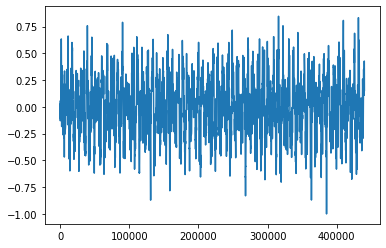

In [ ]:
import matplotlib.pyplot as plt

plt.plot(scale(left_df))
plt.show()

To give a rough intuition, half of one x-tick is about a single second - we can already see by eye that the predominant frequencies are subsonic using this sampling technique.

To be more sure of what is going on, it makes sense to make a cumulative welch which reveals the "energy" of different frequencies across the audio file.

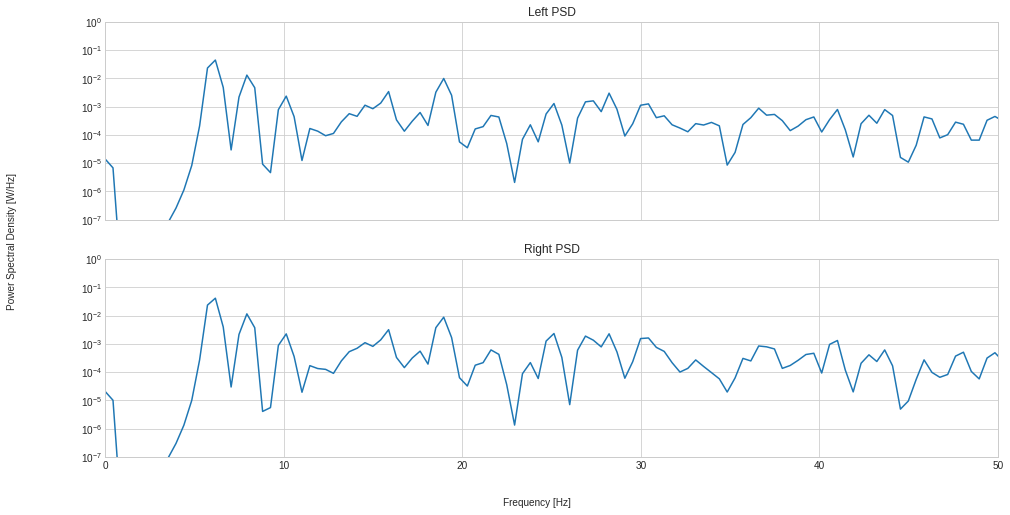

In [175]:
from scipy.signal import welch

fl,P_left = welch(scale(left_df),44100,nperseg=100000)
fr,P_right = welch(scale(right_df),44100,nperseg=100000)

# Matplotlib boilerplate
fig,axs = plt.subplots(2,1,figsize=(16,8),sharex=True)
axs[0].semilogy(fl,P_left)
axs[1].semilogy(fr,P_right)

# # # Focus on a particular region of the PSD
axs[0].set_ylim([1e-7,1])
axs[1].set_ylim([1e-7,1])
axs[0].set_xlim([0,50])

# Make common axis labels
fig.text(0.5, 0.04, 'Frequency [Hz]', ha='center')
fig.text(0.04, 0.5, 'Power Spectral Density [W/Hz]', va='center', rotation='vertical')

# Set titles
axs[0].set_title("Left PSD")
axs[1].set_title("Right PSD")

plt.show()

Here is where the similarities between the two drums become really obvious. The power per frequency is clearly very similar for the two drums.

To quantify how well these two spectra line up, we will measure the Coherence.

The coherence depends on two assumptions:

1. That our system is linear, which is true as the Laplace-Beltrami operator is linear.

2. That our *signal* is ergodic, which we can assume to be true as the time series is stationary.

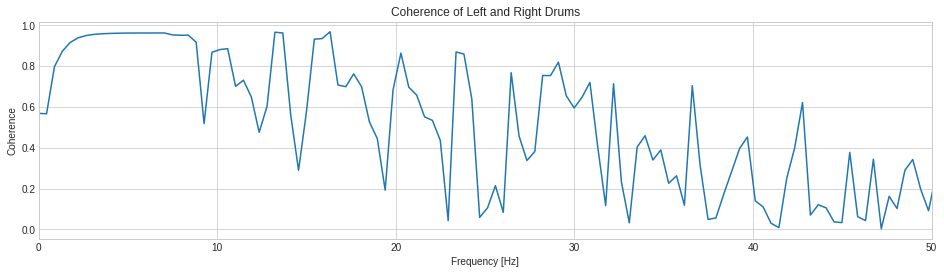

In [174]:
from scipy.signal import coherence

fs, Cxy = coherence(scale(left_df),scale(right_df),44100,nperseg=100000)

fig,ax = plt.subplots(1,1,figsize=(16,4))

ax.plot(fs,Cxy)
ax.set_xlim([0,50])
ax.set_title("Coherence of Left and Right Drums")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Coherence")

plt.show()

Here we get some very strong coherences on our peaks close to the peaks of the PSDs we saw above - this is a pretty good sign.

Now let us see if we can determine if we are listening to homophonic drums - this would mean that we have precisely the same waveform, which would require the two drums to have exactly the same eigenmodes in its initial state - this is unlikely.

But lets see!

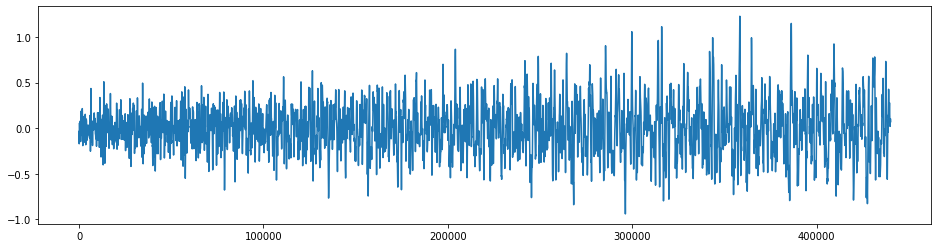

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(scale(left_df)-scale(right_df))

plt.show()

More similar than I'd expect, but the signals end up diverging significantly very quickly. This noise is significantly smaller than the peaks that we see in the data.

Since the region is homophonic and all normalized eigenfunctions at the distinguished point take the same value, we should expect that a maxima at this distinguished point represents a maxima in all the eigenfunctions at this point.

Owing to the fact that eigenfunctions on closed dirichlet boundaries are periodic, we then expect that the timing between these peaks should be synchronized.

Let's check this assumption now

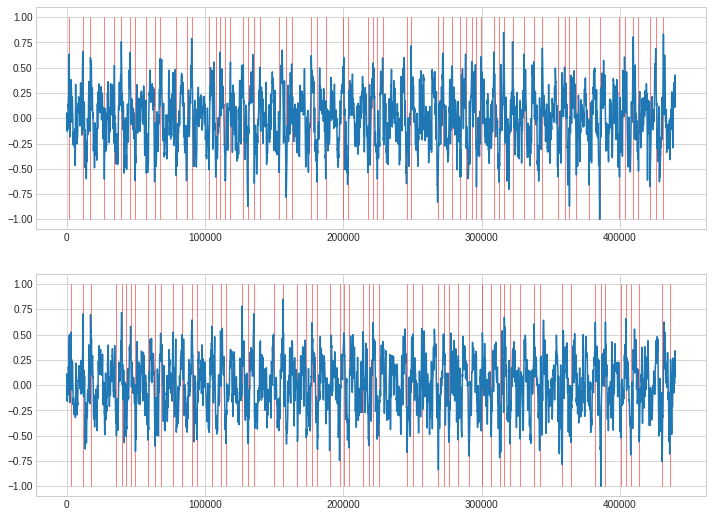

In [152]:
from scipy.signal import find_peaks

left_peaks = find_peaks(abs(scale(left_df)),distance=3000,height=0.5)[0]
right_peaks = find_peaks(abs(scale(right_df)),distance=3000,height=0.5)[0]

fig,axs = plt.subplots(2,1,figsize=(12,9))

axs[0].plot(scale(left_df))
axs[1].plot(scale(right_df))
axs[0].vlines(left_peaks,-1,1,linewidth=0.5,color='r')
axs[1].vlines(right_peaks,-1,1,linewidth=0.5,color='r')

Now that we have some points which we can atleast assess by eye have a similar "peak", let's try and find some pairs looking through both arrays and then measure their distances

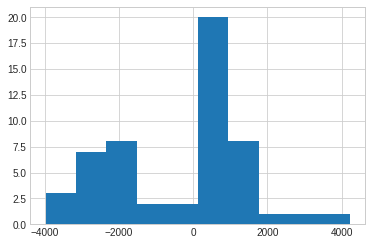

In [168]:
from scipy.stats import describe

pairs_list = [(0,0)]

# Quick script to get closest pairs
for idx,i in enumerate(right_peaks.tolist()):
  left_pair = abs(left_peaks-i).argmin()
  if left_pair != pairs_list[-1][1]:
      pairs_list.append((idx,left_pair))

out_list = []

# Quick script to extract differences
for pair in pairs_list:
  out_list.append(right_peaks[pair[0]]-left_peaks[pair[1]])

# Plot a histogram
plt.hist(np.array(out_list))
plt.show()

This is pretty nice, a lot of peaks are lining up, but quite a few seem to be desynced at about 3000 time steps, perhaps these come from later in the simulation?

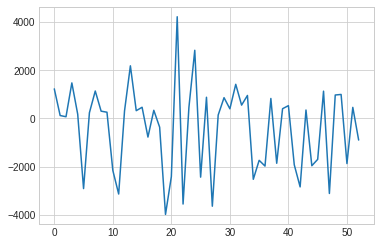

In [170]:
plt.plot(out_list)

Hmmm... no clear reason for this. It's worth noting that 3000 steps only makes for about 7ms of delay in the audio and in the simulation there is a difference of about 0.3s difference - probably imperceptible by eye. 